### Segment huaman cells (in mitosis)
[link to example](https://scikit-image.org/docs/stable/auto_examples/applications/plot_human_mitosis.html#sphx-glr-auto-examples-applications-plot-human-mitosis-py)

In this example, we analyze a microscopy image of human cells.

c:\Users\AdamSz\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


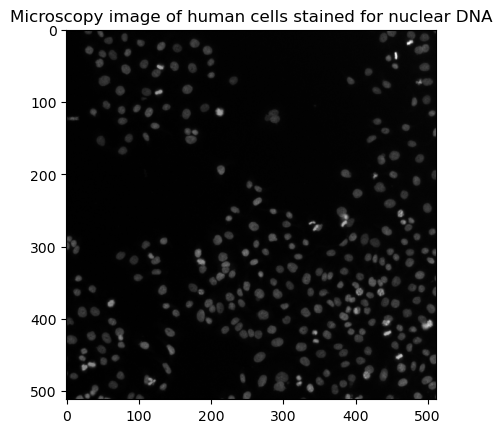

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import skimage

image = skimage.data.human_mitosis()

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
ax.set_title("Microscopy image of human cells stained for nuclear DNA")
plt.show()

We see many cell nuclei on a dark background. Most of them are smooth and have an ellipitical shape.
However, we can distinguish some brighter spots corresponding to nuclei undergoing mitosis (cell division).

Another way of visualizing a grayscale image is contour plotting:

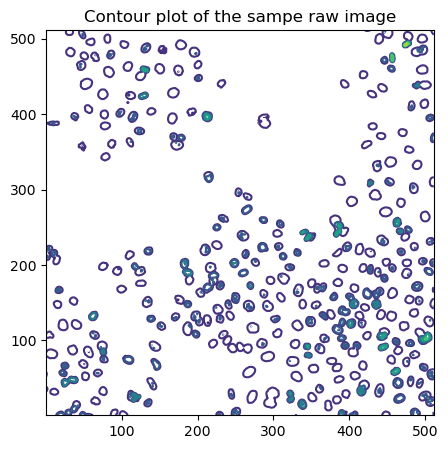

In [2]:
fig, ax = plt.subplots(figsize=(5,5))
qcs = ax.contour(image, origin='image')
ax.set_title('Contour plot of the sampe raw image')
plt.show()

The contour lines are drawn at these levels:

In [3]:
qcs.levels

array([  0.,  40.,  80., 120., 160., 200., 240., 280.])

Each level has, respectively, the following numbers of segments:

In [4]:
[len(seg) for seg in qcs.allsegs]

[0, 320, 270, 48, 19, 3, 1, 0]

#### Estimate the mitotic index

Cell biology uses the mitotic index to quantify cell division and, hence, cell proliferation. By definition, it is the ratio of cells in mitosis over the total number of cells. To analyze the above image, we are thus interested in two thresholds: one separating the nuclei from the background, theother separating the dividing nuclei (brighter spots)from the non-dividing nuclei. To separate these different classes of pixels, we resort to Multi-Otsu Thresholding. 

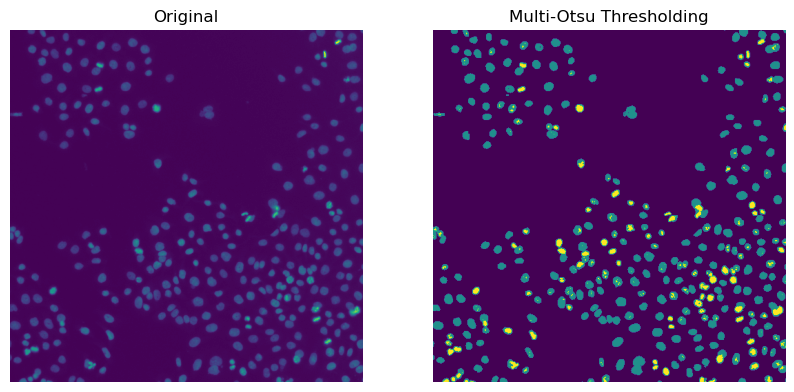

In [5]:
thresholds = skimage.filters.threshold_multiotsu(image, classes=3)
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(regions)
ax[1].set_title('Multi-Otsu Thresholding')
ax[1].axis('off')
plt.show()


Since there are overlapping nuclei, thresholding is not enough to segment all the nuclei. If it were, we could readily compute a mitotic index for this sample:

In [6]:
cells = image > thresholds[0]
dividing = image > thresholds[1]
labeled_cells = skimage.measure.label(cells)
labeled_dividing = skimage.measure.label(dividing)
naive_mi = labeled_dividing.max() / labeled_cells.max()
print(f"naive mitotic index: {naive_mi}")

naive mitotic index: 0.7847222222222222


Whoa, this can't be! The number of dividing nuclei:

In [7]:
labeled_dividing.max()

226

is overestimated, while the total number of cells:

In [8]:
labeled_cells.max()

288

is underestimated.

(-0.5, 511.5, 511.5, -0.5)

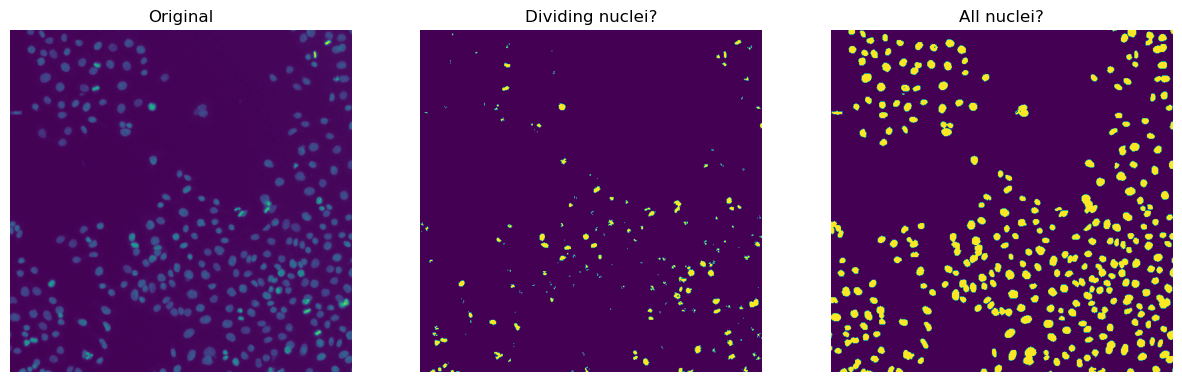

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(image)
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(dividing)
ax[1].set_title("Dividing nuclei?")
ax[1].axis('off')

ax[2].imshow(cells)
ax[2].set_title("All nuclei?")
ax[2].axis("off")

#### Count dividing nuclei
Clearly, not all connected regions in the middle plot are dividing nuclei. On one hand, the second threshold (value of `thresholds[1]`) appears to be too low to separate those very bright areas corresponding to dividing nuclei from relatively bright pixels otherwise present in many nuclei. On the other hand, we want a smoother image, removing small spurious objects and, possibly, merging clusters of neighbouring objects (some could correspond to two nuclei emerging from one cell division). In a way, the segmentation challenge we are facing with dividing nuclei is the opposite of that with (touching) cells.

To find suitable values for thresholds and filtering parameters, we proceed by dichtomy, visually and manually.

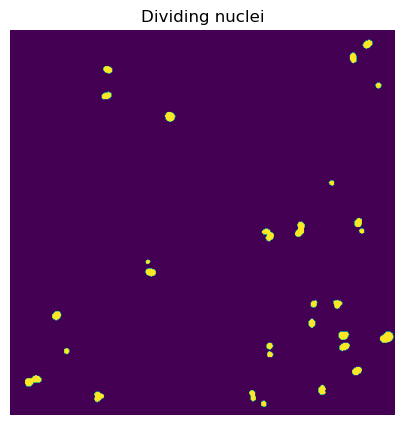

In [10]:
higher_threshold = 125
dividing = image > higher_threshold

smoother_dividing = skimage.filters.rank.mean(
    skimage.util.img_as_ubyte(dividing),
    skimage.morphology.disk(4)
)

binary_smoother_dividing = smoother_dividing > 20

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(binary_smoother_dividing)
ax.set_title("Dividing nuclei")
ax.axis('off')
plt.show()

We are left with:

In [11]:
cleaned_dividing = skimage.measure.label(binary_smoother_dividing)
cleaned_dividing.max()

29

dividing nuclei in this sample.

#### Segment nuclei
To separate overlapping nuclei, we resort to Watershed segmentation. To visualize the segmenation conveniently, we colour-code the labeled regions using the `skimage.color.label2rgb` function, specyfiying the background label with argument *bg_label=0*

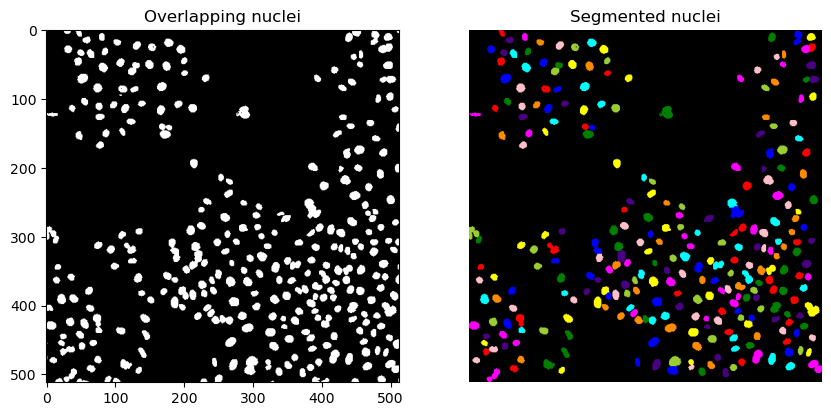

In [12]:
distance = ndimage.distance_transform_edt(cells)

local_max_coords = skimage.feature.peak_local_max(distance, min_distance=7)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = skimage.measure.label(local_max_mask)

segmented_cells = skimage.segmentation.watershed(-distance, markers, mask=cells)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(cells, cmap='gray')
ax[0].set_title('Overlapping nuclei')
ax[1].imshow(skimage.color.label2rgb(segmented_cells, bg_label=0))
ax[1].set_title("Segmented nuclei")
ax[1].axis('off')
plt.show()

Additionally, we may use function `skimage.color.label2rgb` to overlay the original image with segmentation result, using transparency (alpha parameter).

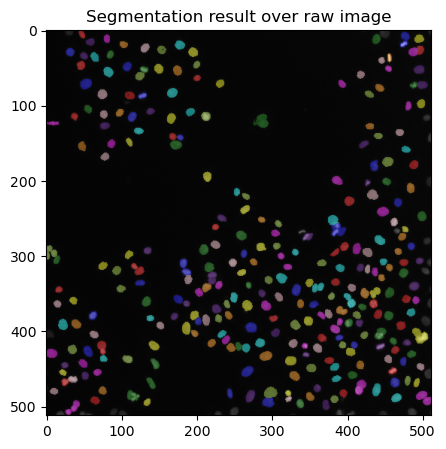

In [13]:
color_labels = skimage.color.label2rgb(segmented_cells, image, alpha=0.4, bg_label=0)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(color_labels)
ax.set_title('Segmentation result over raw image')
plt.show()

In [14]:
segmented_cells.max()

286

cells in this sample. Therefore, we estimate the mitotic index to be:

In [15]:
print(f"estimated mitotic index={cleaned_dividing.max() / segmented_cells.max()}")

estimated mitotic index=0.10139860139860139
